## Import Packages


In [1]:
import numpy as np
import pandas as pd
from PIL import Image 
import matplotlib.pyplot as plt
%matplotlib inline

import torch 
import torch.nn.functional as F
import cv2
import os

from torchvision import transforms, models


In [5]:

# os.chdir('../')
os.getcwd()


'c:\\Users\\sussh\\Documents\\CODES\\Python\\python_phase2\\Grad_CAM'

## Preprocessing Image


In [6]:
img = Image.open('face.jpg')

In [16]:
preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean = [0.445, 0.456, 0.406],
        std = [0.225, 0.224, 0.229]
    )
])

img_tensor = preprocess(img).unsqueeze(0)
img_tensor.shape

torch.Size([1, 3, 224, 224])

## Restnet Model

In [29]:
restnet_model = models.resnet50(pretrained=True)
restnet_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
vgg_model = models.vgg16(pretrained=True)
vgg_model.eval()

In [17]:
class GradCAM:
    def __init__ (self, model, target_layer) -> None:
        self.model = model
        self.target_layer = target_layer
        self.activation_maps = None
        self.gradient_maps = None
        self.hook()

    def hook(self):
        def forward_hook(module, in_activation_maps, out_activation_maps):
            self.activation_maps = out_activation_maps

        def backward_hook(module, grad_in, grad_out):
            self.gradient_maps = grad_out[0]

        target_layer_module = dict([*self.model.named_modules()])[self.target_layer]
        target_layer_module.register_forward_hook(forward_hook)
        target_layer_module.register_backward_hook(backward_hook)

    def generate_cam(self, input_tensor, class_name):  # Fix: add class_name parameter
        output = self.model(input_tensor)
        class_indices = {
            'dog' : 207,
            'horse': 339,
            'person': 15
        }

        if class_name not in class_indices:
            raise ValueError(f'{class_name} not supported')
        class_idx = class_indices[class_name]
        self.model.zero_grad()

        target_class = output[:, class_idx]
        target_class.backward()

        # Compute Global Average Pooling
        weights = torch.mean(self.gradient_maps, dim=[2,3])

        cam = torch.zeros(self.activation_maps.shape[2:], dtype=torch.float32)  # Fix: match the shape of activation maps

        for i, w in enumerate(weights[0]):
            cam += w * self.activation_maps[0, i, :, :]

        cam = F.relu(cam)
        

        return (cam - cam.min()) / (cam.max() - cam.min()), class_idx
        
grad_cam = GradCAM(restnet_model, 'layer4')
class_name = 'dog'
cam, class_idx = grad_cam.generate_cam(img_tensor, class_name)

c:\Users\sussh\Documents\CODES\Python\python_phase2\Grad_CAM\venv\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


In [110]:
original_img = np.array(img)
if original_img.ndim == 2:
    original_img = cv2.cvtColor(original_img, cv2.COLOR_GRAY2BGR)
else:
    original_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2BGR)

original_img = np.float32(original_img) / 255


In [ ]:

cam = cam.detach().cpu().numpy()  # Convert tensor to numpy array
cam = cv2.resize(cam, (original_img.shape[1], original_img.shape[0]))
heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)

overlay = heatmap / 255 + original_img
overlay = overlay / np.max(overlay)

plt.imshow(overlay)
plt.axis('off')
plt.show()

## GradCAM for nose, mouth and eyes

In [61]:
class FaceKeypointData:
    def __init__(self, img_path='face.jpg', model_input_size=(224, 224), device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
        self.img_path = img_path
        self.model_input_size = model_input_size
        self.device = device
        
        self.keypoint_model = torch.load('model/version_3/model.pth', map_location=self.device)
        self.keypoint_model.eval()  

    def preprocess_image(self):
        preprocess = transforms.Compose([
            transforms.Resize(self.model_input_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        img = Image.open(self.img_path).convert('RGB')
        img_tensor = preprocess(img).unsqueeze(0)  
        return img_tensor, np.array(img)  

    def get_keypoints(self, img_tensor):
        with torch.no_grad():  
            output = self.keypoint_model(img_tensor)  
            keypoints = output.squeeze().cpu().numpy() 

        original_size = np.array([self.model_input_size[0], self.model_input_size[1]])
        kp_normalized = keypoints / original_size[:, None]  
        return kp_normalized.flatten()  

C:\Users\sussh\AppData\Local\Temp\ipykernel_3264\213627109.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.keypoint_model = torch.load('model/version_3/model.pth', 

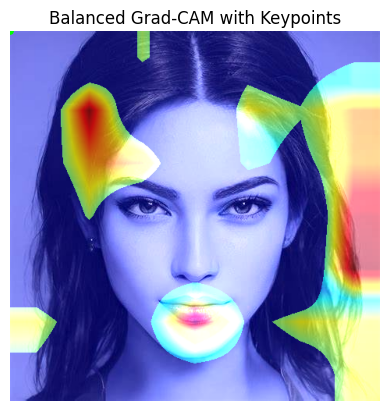

In [69]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradient_maps = None
        self.activation_maps = None
        self.model.eval()
        self.hook()

    def hook(self):
        def forward_hook(module, in_activation_maps, out_activation_maps):
            self.activation_maps = out_activation_maps

        def backward_hook(module, grad_in, grad_out):
            self.gradient_maps = grad_out[0]

        target_layer_module = dict([*self.model.named_modules()])[self.target_layer]
        target_layer_module.register_forward_hook(forward_hook)
        target_layer_module.register_backward_hook(backward_hook)

    def generate_cam(self, input_tensor, class_idx):
        self.model.zero_grad()
        output = self.model(input_tensor)
        target_class = output[:, class_idx]
        target_class.backward()

        gradient_maps = self.gradient_maps.cpu().data.numpy()[0]
        activation_maps = self.activation_maps.cpu().data.numpy()[0]

        weights = np.mean(gradient_maps, axis=(1, 2))
        cam = np.sum(weights[:, np.newaxis, np.newaxis] * activation_maps, axis=0)

        cam = torch.tensor(cam)  
        cam = F.relu(cam)
        return (cam - cam.min()) / (cam.max() - cam.min()), class_idx

 
    def overlay_heatmap(original_image, heatmap, alpha=0.5):
        heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
        combined_image = cv2.addWeighted(original_image, 1, heatmap, alpha, 0)
        return combined_image


    def visualize_cams(grad_cam, img_tensor, original_image, keypoints):
        combined_image = original_image.copy()
        class_indices = {'eyes': 0, 'nose': 1, 'mouth': 2}
        
        heatmaps = []
        for classname, class_idx in class_indices.items():
            cam, _ = grad_cam.generate_cam(img_tensor, class_idx)
            cam_resized = cv2.resize(cam.numpy(), (original_image.shape[1], original_image.shape[0]))  # Convert tensor to numpy array for resizing
            heatmaps.append(cam_resized)

        feature_mask = np.zeros_like(heatmaps[0])
        for heatmap in heatmaps:
            feature_mask += heatmap
        feature_mask = (feature_mask > 0.5).astype(float)

        masked_heatmaps = [heatmap * feature_mask for heatmap in heatmaps]

        combined_heatmap = np.maximum.reduce(masked_heatmaps)

        combined_image = GradCAM.overlay_heatmap(combined_image, combined_heatmap, alpha=0.7)

        for i in range(0, len(keypoints), 2):
            cv2.circle(combined_image, (int(keypoints[i] * original_image.shape[1]), 
                                        int(keypoints[i + 1] * original_image.shape[0])), 
                       3, (0, 255, 0), -1)

        plt.imshow(cv2.cvtColor(combined_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title("Balanced Grad-CAM with Keypoints")
        plt.show()

face_keypoint_data = FaceKeypointData(img_path='face.jpg')
img_tensor, original_image = face_keypoint_data.preprocess_image()
keypoints = face_keypoint_data.get_keypoints(img_tensor)

resnet_model = models.resnet50(pretrained=True)
resnet_model.eval()

balanced_grad_cam = GradCAM(model=resnet_model, target_layer='layer4')
GradCAM.visualize_cams(balanced_grad_cam, img_tensor, original_image, keypoints)